In [2]:
# step 1  Dataset Preprocessing 
import os
import json
import cv2
import numpy as np

# Step 1: Dataset Preparation (COCO-style Annotations)
base_dir = r"E:\python\paddy_images"  # Update with your dataset path
categories = ["paddy without pests", "paddy with pests"]

# Initialize COCO-style annotations structure
annotations = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "paddy_with_pests"}]
}

annotation_id = 1
image_id = 1

# Function to create bounding boxes from polygons
def polygon_to_bbox(polygon):
    x_coords = [point[0] for point in polygon]
    y_coords = [point[1] for point in polygon]
    x_min, y_min = min(x_coords), min(y_coords)
    width, height = max(x_coords) - x_min, max(y_coords) - y_min
    return [x_min, y_min, width, height]

# Prepare annotations for each category
for category in categories:
    category_dir = os.path.join(base_dir, category)
    if not os.path.exists(category_dir):
        print(f"Error: Folder '{category_dir}' not found.")
        continue

    for filename in os.listdir(category_dir):
        if filename.lower().endswith(('.jpg', '.png')):
            image_path = os.path.join(category_dir, filename)

            # Read image and get its dimensions
            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not read image '{image_path}'. Skipping...")
                continue

            height, width, _ = img.shape

            # Add image metadata
            annotations["images"].append({
                "id": image_id,
                "file_name": image_path.replace("\\", "/"),
                "height": height,
                "width": width
            })

            # Add polygon annotation if category is "paddy with pests"
            if category == "paddy with pests":
                polygon = [
                    [int(width * 0.1), int(height * 0.1)],
                    [int(width * 0.9), int(height * 0.1)],
                    [int(width * 0.9), int(height * 0.9)],
                    [int(width * 0.1), int(height * 0.9)]
                ]
                bbox = polygon_to_bbox(polygon)
                annotations["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 1,
                    "segmentation": [np.array(polygon).flatten().tolist()],
                    "bbox": bbox,
                    "area": bbox[2] * bbox[3],
                    "iscrowd": 0
                })
                annotation_id += 1

            image_id += 1

# Save the annotations to a JSON file
output_file = "annotations.json"
with open(output_file, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"Annotations saved to {output_file}")

Annotations saved to annotations.json


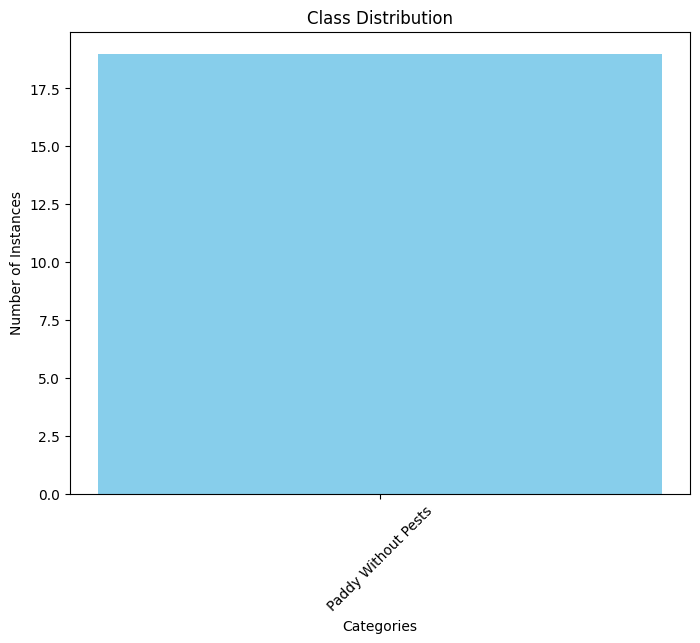

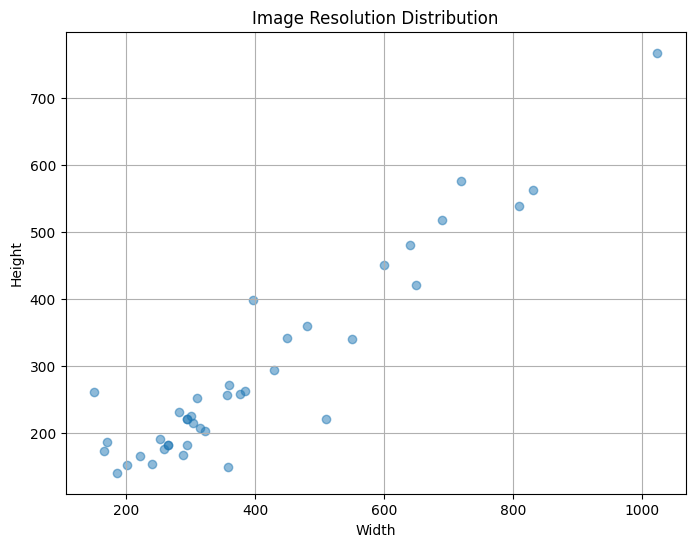

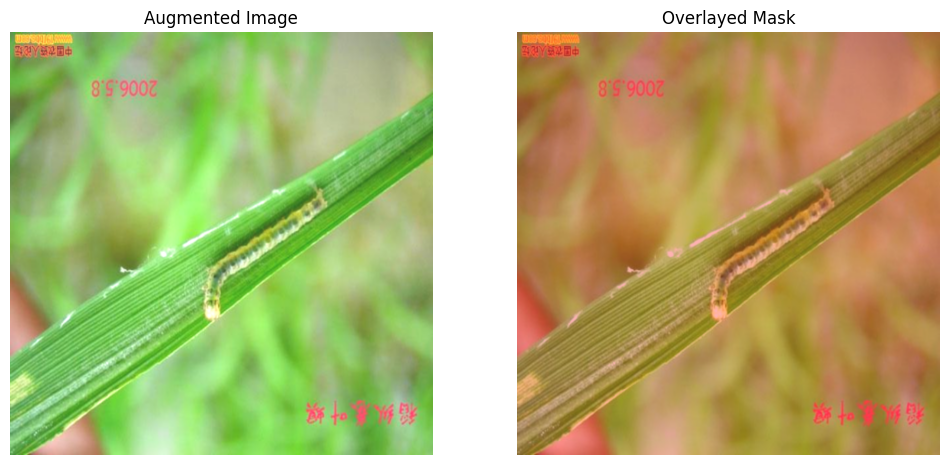

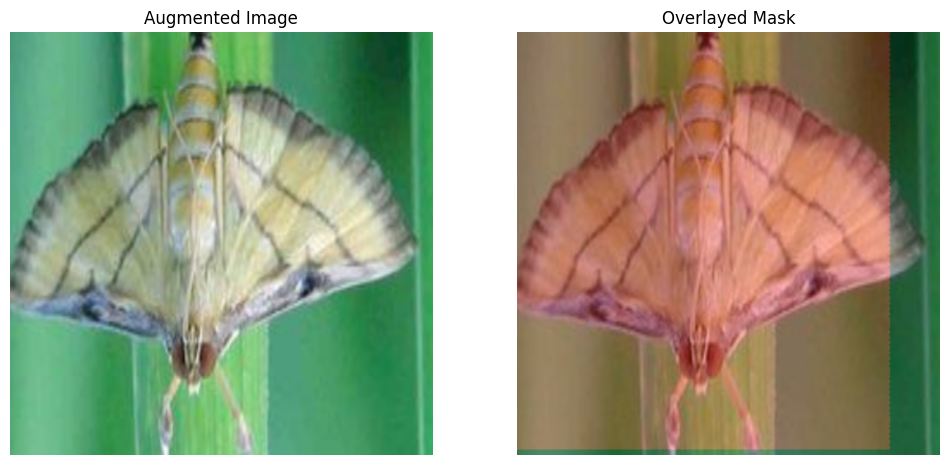

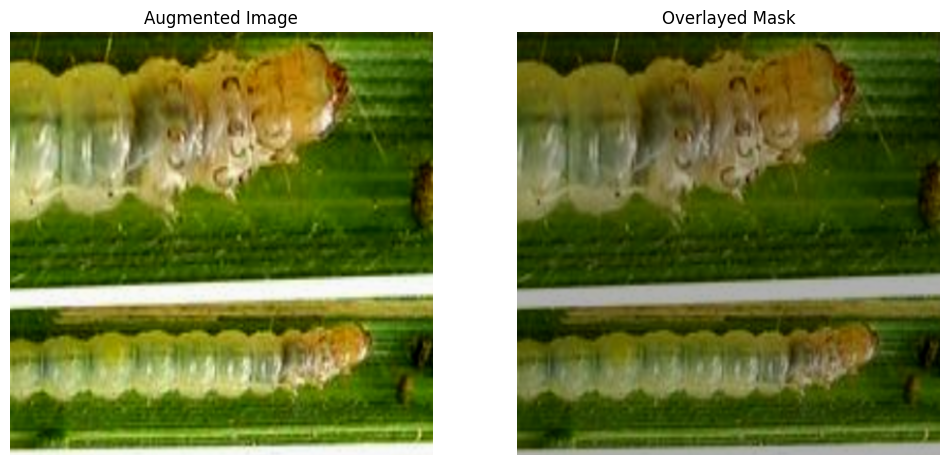

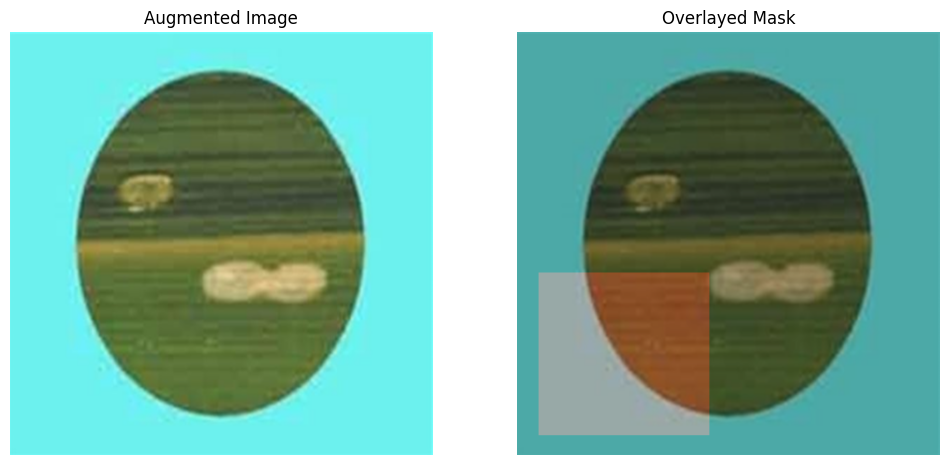

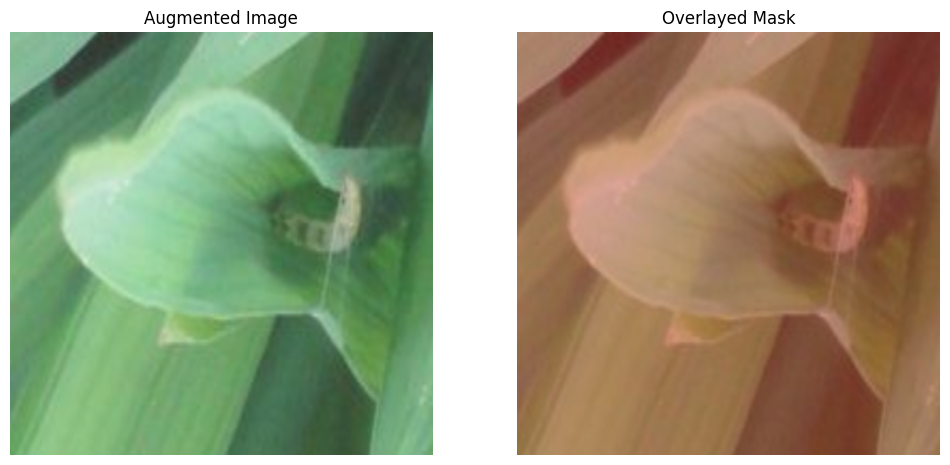

In [8]:
import os
import json
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter

# Paths
ANNOTATIONS_PATH = "annotations.json"
BASE_DIR = "path_to_your_dataset"  # Update with the path to your dataset
CATEGORIES = ["Paddy Without Pests", "Paddy With Pests"]

# Load the COCO-style annotations
with open(ANNOTATIONS_PATH, "r") as file:
    data = json.load(file)

images = data.get("images", [])
annotations = data.get("annotations", [])


# 1. Dataset Analysis
def analyze_dataset(images, annotations):
    resolutions = []
    category_counts = Counter()

    # Collect data for analysis
    for img_info in images:
        resolutions.append((img_info["width"], img_info["height"]))
        img_annotations = [ann for ann in annotations if ann["image_id"] == img_info["id"]]
        for ann in img_annotations:
            category_counts[ann["category_id"]] += 1

    # Map category IDs to names dynamically
    category_id_to_name = {1: "Paddy Without Pests", 2: "Paddy With Pests"}

    # Visualize Class Distribution
    plt.figure(figsize=(8, 6))
    categories = [category_id_to_name.get(cat_id, f"Category {cat_id}") for cat_id in category_counts.keys()]
    plt.bar(categories, category_counts.values(), color="skyblue")
    plt.title("Class Distribution")
    plt.xlabel("Categories")
    plt.ylabel("Number of Instances")
    plt.xticks(rotation=45)
    plt.show()

    # Visualize Resolution Distribution
    if resolutions:
        widths, heights = zip(*resolutions)
        plt.figure(figsize=(8, 6))
        plt.scatter(widths, heights, alpha=0.5)
        plt.title("Image Resolution Distribution")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.grid(True)
        plt.show()
    else:
        print("No resolutions available to display.")


# 2. Data Augmentation Pipeline
augmentations = A.Compose([
    A.Resize(512, 512),  # Resize to consistent dimensions
    A.HorizontalFlip(p=0.5),  # Horizontal flipping
    A.VerticalFlip(p=0.5),  # Vertical flipping
    A.RandomRotate90(p=0.5),  # Random 90-degree rotations
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),  # Combined shift, scale, rotate
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
    A.RandomCrop(400, 400, p=0.5),  # Random cropping
    A.RandomScale(scale_limit=(0.5, 1.5), p=0.5)  # Simulate zooming by scaling
], additional_targets={'mask': 'image'})


# Helper Function: Convert polygon annotations to binary masks
def polygon_to_mask(polygon, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    polygon = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(mask, [polygon], 1)
    return mask


# Augment Image and Mask
def augment_image_and_mask(image_path, polygon, height, width):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image: {image_path}")
        return None, None

    # Resize the image to match expected dimensions
    img = cv2.resize(img, (width, height))

    # Convert polygon to binary mask
    mask = polygon_to_mask(polygon, height, width)

    # Apply augmentations to both the image and mask
    augmented = augmentations(image=img, mask=mask)

    # Ensure the mask remains binary
    augmented_mask = np.where(augmented['mask'] > 0.5, 1, 0).astype(np.uint8)

    return augmented['image'], augmented_mask


# Visualize Augmented Samples
def visualize_augmentations(images, annotations):
    for img_info, ann in zip(images[:5], annotations[:5]):  # Visualize the first 5 samples
        polygon = np.reshape(ann["segmentation"][0], (-1, 2))
        image_path = img_info["file_name"]
        height = img_info["height"]
        width = img_info["width"]

        augmented_img, augmented_mask = augment_image_and_mask(image_path, polygon, height, width)

        if augmented_img is not None and augmented_mask is not None:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            # Display augmented image
            axs[0].imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Augmented Image")
            axs[0].axis("off")

            # Display augmented mask with a blue overlay
            blue_mask = np.zeros_like(augmented_img, dtype=np.uint8)
            blue_mask[augmented_mask == 1] = [0, 0, 255]  # Blue for mask
            overlayed_image = cv2.addWeighted(augmented_img, 0.7, blue_mask, 0.3, 0)

            axs[1].imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
            axs[1].set_title("Overlayed Mask")
            axs[1].axis("off")

            plt.show()


# Main Execution
analyze_dataset(images, annotations)
visualize_augmentations(images, annotations)


In [4]:
# 4. Model Development
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from PIL import Image
import numpy as np
from pycocotools.coco import COCO

class PaddyDataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        """
        Custom dataset for loading images and annotations in COCO format.
        
        :param annotations_file: Path to COCO annotations JSON file.
        :param images_dir: Path to the directory containing images.
        :param transform: Transformations to apply to images.
        """
        self.coco = COCO(annotations_file)
        self.images_dir = images_dir
        self.img_ids = [
            img_id for img_id in self.coco.imgs.keys()
            if len(self.coco.getAnnIds(imgIds=img_id)) > 0
        ]
        self.transform = transform
        print(f"Filtered dataset: {len(self.img_ids)} images with annotations.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # Load image metadata
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.images_dir, img_info["file_name"])

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []

        for ann in anns:
            # Convert segmentation to mask
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            # Extract bounding box
            bbox = ann["bbox"]
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])

            # Extract category label
            labels.append(ann["category_id"])

        # Convert to tensors
        image = F.to_tensor(np.array(image, copy=True)).float()
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor([ann["area"] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.tensor([ann["iscrowd"] for ann in anns], dtype=torch.int64),
        }

        return image, target

# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))


# Training Mask-RCNN
def train_mask_rcnn(dataset, num_epochs=10, batch_size=4, learning_rate=0.005):
    """
    Train a Mask-RCNN model using a custom dataset.

    :param dataset: Dataset instance (PaddyDataset).
    :param num_epochs: Number of training epochs.
    :param batch_size: Batch size for DataLoader.
    :param learning_rate: Learning rate for optimizer.
    """
    # Load the dataset and DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Initialize the Mask-RCNN model
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = maskrcnn_resnet50_fpn(weights=weights)
    num_classes = len(dataset.coco.getCatIds()) + 1  # Add 1 for the background class
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Move the model to GPU if available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, targets in dataloader:
            # Move data to GPU
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward pass
            losses.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "mask_rcnn_paddy.pth")
    print("Model training complete and saved to mask_rcnn_paddy.pth!")


if __name__ == "__main__":
    # Define paths to annotations and images
    annotations_file = "annotations.json"  # Update with the correct path
    images_dir = "images"  # Update with the correct path

    # Initialize the dataset
    dataset = PaddyDataset(annotations_file, images_dir)

    # Train the model
    train_mask_rcnn(dataset, num_epochs=10, batch_size=4)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Filtered dataset: 19 images with annotations.
Epoch 1/10, Loss: 6.0968
Epoch 2/10, Loss: 2.3648
Epoch 3/10, Loss: 1.9079
Epoch 4/10, Loss: 1.7192
Epoch 5/10, Loss: 1.9761
Epoch 6/10, Loss: 1.6008
Epoch 7/10, Loss: 1.5012
Epoch 8/10, Loss: 1.2836
Epoch 9/10, Loss: 1.2552
Epoch 10/10, Loss: 1.1912
Model training complete and saved to mask_rcnn_paddy.pth!


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved heatmap_boundingbox_0.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved heatmap_boundingbox_1.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved heatmap_boundingbox_2.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved heatmap_boundingbox_3.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved heatmap_boundingbox_4.png


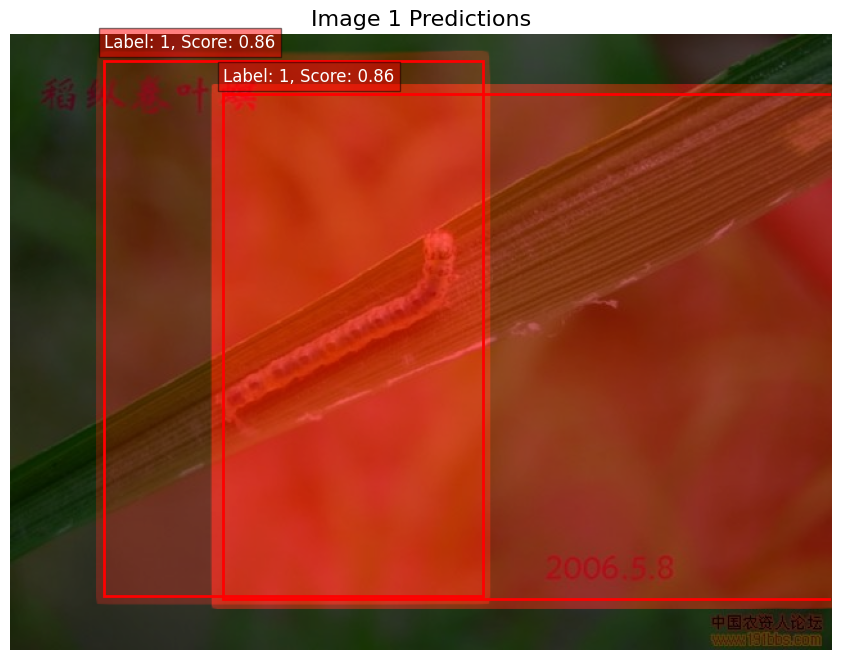

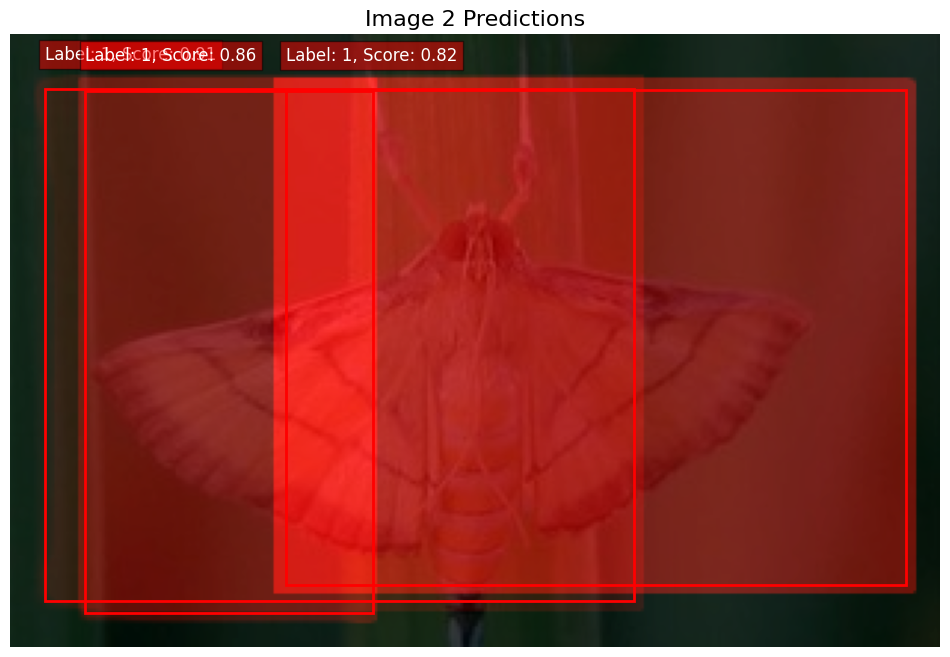

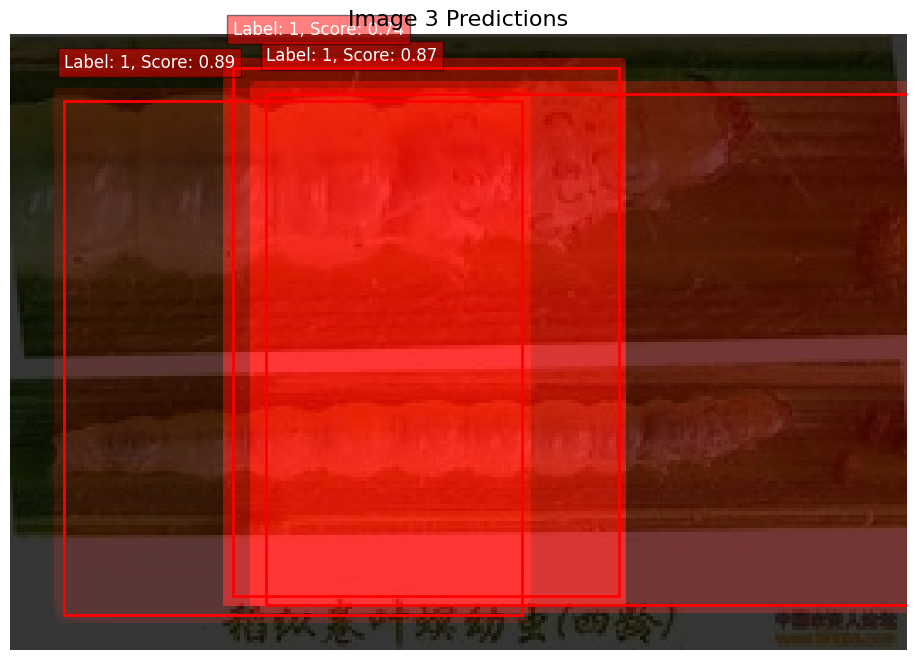

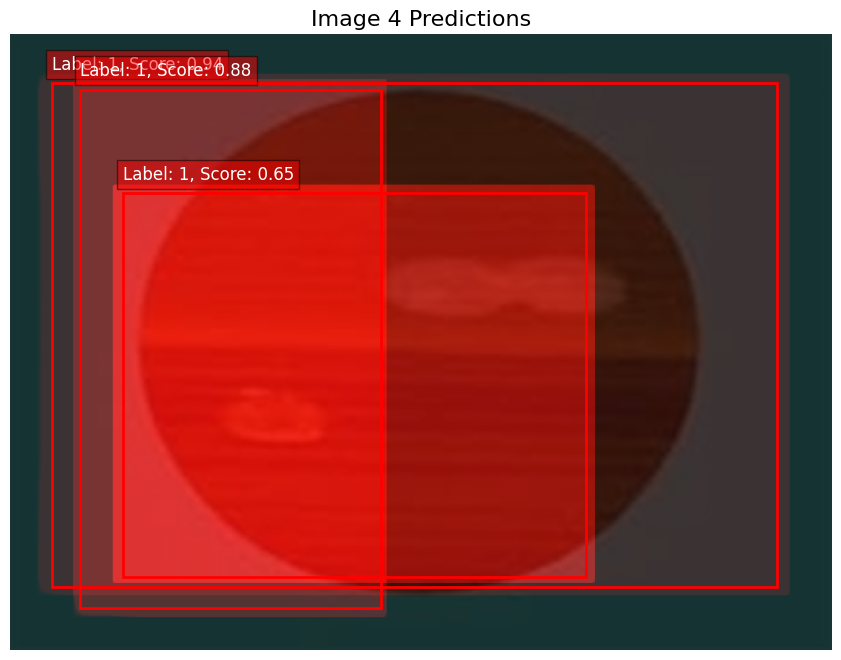

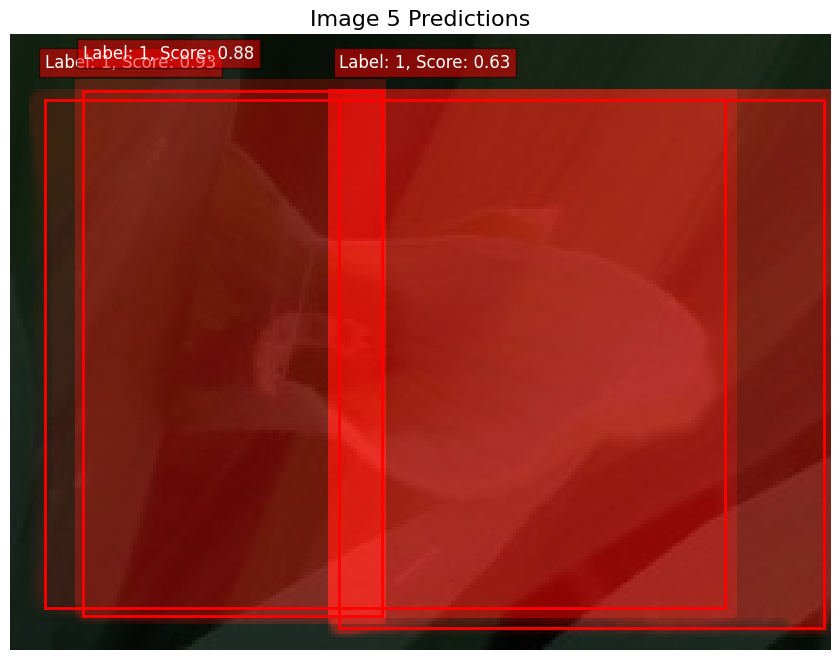

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torchvision.datasets import CocoDetection


class PaddyDataset(CocoDetection):
    """
    Custom Dataset class for loading images and annotations.
    """
    def __init__(self, annotations_file, images_dir, transforms=None):
        super().__init__(images_dir, annotations_file)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img = F.to_tensor(img)  # Convert PIL image to tensor
        return img, target


def visualize_predictions_with_heatmaps(
    model, dataset, device, num_images=5, score_threshold=0.5, save_outputs=False
):
    """
    Visualize predictions with bounding boxes and heatmaps for qualitative analysis.

    :param model: Trained Mask R-CNN model.
    :param dataset: Dataset instance.
    :param device: Device to use for inference (CPU or GPU).
    :param num_images: Number of images to visualize.
    :param score_threshold: Confidence score threshold for predictions.
    :param save_outputs: Whether to save visualizations as image files.
    """
    model.eval()

    for i in range(min(num_images, len(dataset))):
        # Load the image and target from the dataset
        image, target = dataset[i]
        image = image.to(device)
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Make predictions
        with torch.no_grad():
            prediction = model([image])

        # Extract predictions
        pred_boxes = prediction[0]["boxes"].cpu().numpy()
        pred_labels = prediction[0]["labels"].cpu().numpy()
        pred_scores = prediction[0]["scores"].cpu().numpy()
        pred_masks = prediction[0]["masks"].cpu().numpy()

        # Filter predictions by score threshold
        indices = pred_scores > score_threshold
        pred_boxes = pred_boxes[indices]
        pred_labels = pred_labels[indices]
        pred_masks = pred_masks[indices]
        pred_scores = pred_scores[indices]

        # Plot the image
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image_np)
        ax.set_title(f"Image {i+1} Predictions", fontsize=16)

        # Plot predictions
        for box, label, mask, score in zip(pred_boxes, pred_labels, pred_masks, pred_scores):
            # Draw bounding box
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

            # Add label and score
            ax.text(
                x1, y1 - 10, f"Label: {label}, Score: {score:.2f}",
                color="white", fontsize=12, bbox=dict(facecolor="red", alpha=0.5)
            )

            # Overlay mask as a heatmap
            mask = mask[0]  # Extract binary mask
            heatmap = np.zeros_like(image_np)
            heatmap[:, :, 0] = mask * 255  # Use red channel for heatmap
            ax.imshow(heatmap, alpha=0.4, cmap="jet")  # Add heatmap overlay

        plt.axis("off")

        # Save or show the visualization
        if save_outputs:
            plt.savefig(f"heatmap_boundingbox_{i}.png", bbox_inches="tight")
            print(f"Saved heatmap_boundingbox_{i}.png")
        else:
            plt.show()


if __name__ == "__main__":
    # File paths
    annotations_file = r"E:\python\annotations.json"
    images_dir = r"E:\python\Mask_RCNN\images"  # Adjust the images directory path as necessary
    model_path = r"E:\python\mask_rcnn_paddy.pth"

    # Initialize the dataset
    dataset = PaddyDataset(annotations_file, images_dir)

    # Load the trained Mask-RCNN model
    model = maskrcnn_resnet50_fpn()
    num_classes = len(dataset.coco.getCatIds()) + 1
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))

    # Move model to device
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Visualize predictions with heatmaps and bounding boxes
    visualize_predictions_with_heatmaps(
        model, dataset, device, num_images=5, score_threshold=0.5, save_outputs=True
    )


Evaluation Results:
Mean IoU: 0.5355
Mean Average Precision (mAP): 0.8567
Pixel Accuracy: 0.8119


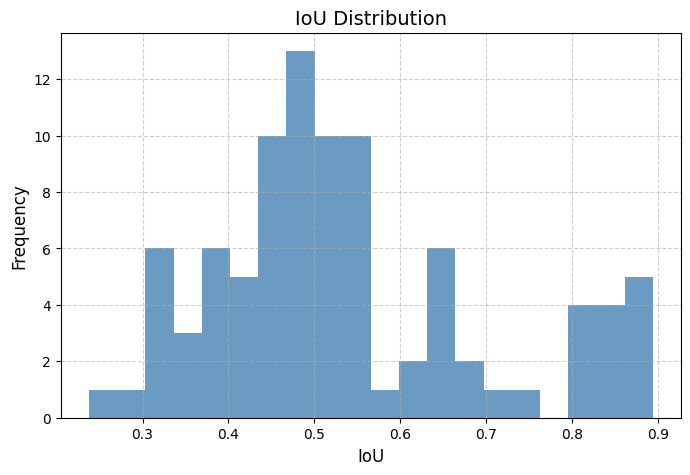

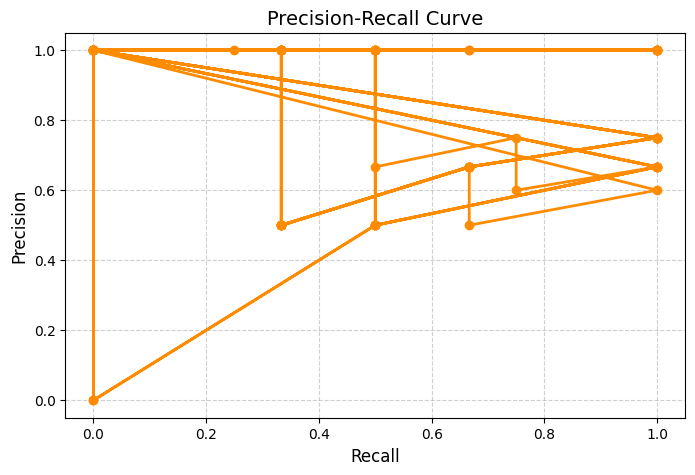

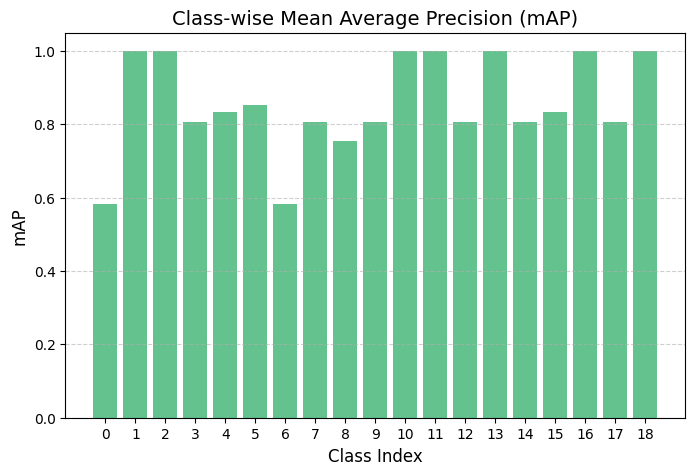

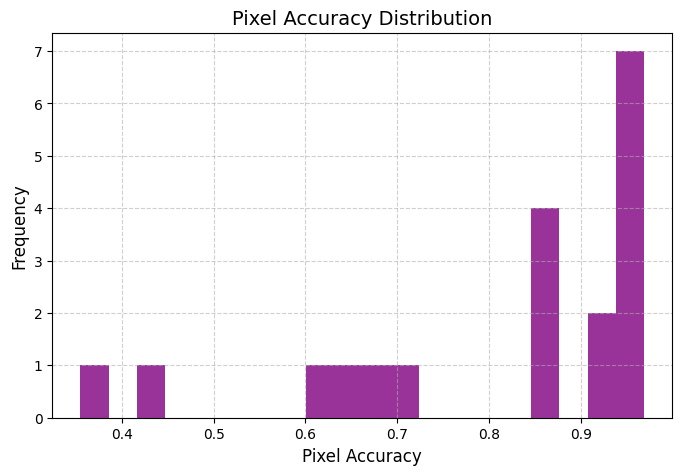

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.ops import box_iou
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_evaluation_results(all_ious, class_precisions, class_recalls, class_aps, pixel_accuracies):
    """
    Plot visualizations for IoU, Precision-Recall Curve, mAP, and Pixel Accuracy.
    """
    # IoU Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(all_ious, bins=20, color="steelblue", alpha=0.8)
    plt.title("IoU Distribution", fontsize=14)
    plt.xlabel("IoU", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # Precision-Recall Curve
    if class_precisions and class_recalls:
        plt.figure(figsize=(8, 5))
        plt.plot(class_recalls, class_precisions, marker='o', color='darkorange', linewidth=2)
        plt.title("Precision-Recall Curve", fontsize=14)
        plt.xlabel("Recall", fontsize=12)
        plt.ylabel("Precision", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

    # mAP Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(class_aps)), class_aps, color="mediumseagreen", alpha=0.8)
    plt.title("Class-wise Mean Average Precision (mAP)", fontsize=14)
    plt.xlabel("Class Index", fontsize=12)
    plt.ylabel("mAP", fontsize=12)
    plt.xticks(range(len(class_aps)))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    # Pixel Accuracy Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(pixel_accuracies, bins=20, color="purple", alpha=0.8)
    plt.title("Pixel Accuracy Distribution", fontsize=14)
    plt.xlabel("Pixel Accuracy", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


def evaluate_model_with_visuals(model, dataset, iou_threshold=0.5, device=None):
    """
    Evaluate a Mask-RCNN model on a dataset and plot visualizations.
    """
    # Standard evaluation logic
    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    model.eval()
    model.to(device)
    
    all_ious = []
    class_precisions = []
    class_recalls = []
    class_aps = []
    pixel_accuracies = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            image, target = dataset[idx]
            image = image.to(device)
            target = {k: v.to(device) for k, v in target.items()}
            image = image.unsqueeze(0)

            # Run model predictions
            output = model(image)
            pred_boxes = output[0]["boxes"]
            pred_masks = output[0]["masks"] > 0.5
            pred_scores = output[0]["scores"]
            pred_labels = output[0]["labels"]

            true_boxes = target["boxes"]
            true_masks = target["masks"]
            true_labels = target["labels"]

            # IoU Calculation
            ious = box_iou(pred_boxes, true_boxes).cpu().numpy()
            if ious.size > 0:
                all_ious.extend(ious.max(axis=1))

            # Precision-Recall Calculation per Class
            for class_id in torch.unique(true_labels):
                true_class_mask = true_labels == class_id
                pred_class_mask = pred_labels == class_id

                class_ious = box_iou(pred_boxes[pred_class_mask], true_boxes[true_class_mask]).cpu().numpy()
                class_scores = pred_scores[pred_class_mask].cpu().numpy()

                if class_ious.size > 0:
                    ap = average_precision_score((class_ious.max(axis=1) > iou_threshold).astype(np.int32), class_scores)
                    precision, recall, _ = precision_recall_curve((class_ious.max(axis=1) > iou_threshold).astype(np.int32), class_scores)
                    class_precisions.extend(precision)
                    class_recalls.extend(recall)
                    class_aps.append(ap)

            # Pixel Accuracy Calculation
            for pred_mask, true_mask in zip(pred_masks, true_masks):
                pred_mask_resized = torch.nn.functional.interpolate(
                    pred_mask.unsqueeze(0).float(), size=true_mask.shape[-2:], mode="bilinear", align_corners=False
                ).squeeze(0) > 0.5

                pred_mask_binary = pred_mask_resized.byte()
                true_mask_binary = true_mask.byte()

                intersection = (pred_mask_binary & true_mask_binary).sum().item()
                union = (pred_mask_binary | true_mask_binary).sum().item()
                
                if union > 0:
                    pixel_accuracy = intersection / union
                    pixel_accuracies.append(pixel_accuracy)

    # Compute Final Metrics
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    mean_ap = np.mean(class_aps) if class_aps else 0.0
    mean_pixel_accuracy = np.mean(pixel_accuracies) if pixel_accuracies else 0.0

    results = {
        "Mean IoU": mean_iou,
        "Mean Average Precision (mAP)": mean_ap,
        "Pixel Accuracy": mean_pixel_accuracy,
    }

    print("Evaluation Results:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot visualizations
    plot_evaluation_results(all_ious, class_precisions, class_recalls, class_aps, pixel_accuracies)

    return results


if __name__ == "__main__":
    from torchvision.models.detection import maskrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    # Example dataset and model loading
    model = maskrcnn_resnet50_fpn(weights=None)
    num_classes = len(dataset.coco.getCatIds()) + 1  # Background + actual classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load("mask_rcnn_paddy.pth"))

    results = evaluate_model_with_visuals(model, dataset)
